# Import Packages

In [1]:
# --------------------------------------
import pandas as pd
import numpy as np
# --------------------------------------
import requests
import json
# --------------------------------------
# ------------- visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# --------------------------------------


# ---------------------------------------
import sklearn
from sklearn import preprocessing, metrics, pipeline, model_selection, feature_extraction 
from sklearn import naive_bayes, linear_model, svm, neural_network, neighbors, tree
from sklearn import decomposition, cluster

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# ---------------------------------------


# ----------------- output and visualizations: 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# --------- for map
import matplotlib.image as mpimg
# --------  metrics:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer

# Load the Data

### Load from the API
URL includes the API link from which we pull the data from

response variable will fatch this data

jprnt function makes data more readable for the human eye

In [2]:
URL = 'https://data.gov.il/api/3/action/datastore_search?resource_id=ecf37201-e71a-4af5-99a5-062fdf07a38d'
response = requests.get(URL)

In [3]:
response

<Response [200]>

In [4]:
#print(response.json()) #see what data we recieve

In [5]:
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [6]:
#jprint(response.json())

### Load to DataFrame
The function here will take that data, and put it in panda's Dataframe table. We'll be using pandas to clear the data for machine learning.

Note that the '_id' column has been set to DataFrame's count index, which starts from 1 and not a 0

In [7]:
def load_query_result_to_df(response): #offset=12500
    response_json = response.json()
    response_result = response_json['result']
    response_fields = response_result['records']
    total = response_result['total'] #total amount of data
    
    df = pd.DataFrame(response_fields)
    for page_num in range (125):
        url = "https://data.gov.il/api/3/action/datastore_search?resource_id=ecf37201-e71a-4af5-99a5-062fdf07a38d&offset=" + str(page_num*100)
        responseNext = requests.get(url)
        response_json = responseNext.json()
        response_result = response_json['result']
        response_fields = response_result['records']
        df2 = pd.DataFrame(response_fields)
        df = df.append(df2)
    return df

In [8]:
df_results = load_query_result_to_df(response)

In [9]:
#df_results

In [10]:
df = df_results.set_index('_id') #sets the index to be as it was set in the API data

# Data Cleaning
Important notes:

Humrat_Teuna - Severity of accident. 1 highest, 3 lowest. We use this as our prediction target

Sug_Teuna - from 1 to 20, type of accident that accured.

Speculation: They are both correlated

===

remove_coord_nan(df) - removes the NAN values for X and Y columns
remove_duplicates(df) - removes any perfect duplicates in the data


In [11]:
def remove_coord_nan(df):
    df_c = df.copy()
    df_c = df.dropna(subset=['X', 'Y'])
    return df_c

In [12]:
def remove_duplicates(df):
    df_c = df.copy()
    df_c.drop_duplicates(keep='first', inplace=True)
    return df_c

In the cell below we have checked the sum of all nan values before and after cleaning to make sure they were indeed remove.

In [13]:
#df['X'].isna().sum() #Checking how many nan values in here
#df['Y'].isna().sum()
df_coord = remove_duplicates(df)
df_coord = remove_coord_nan(df_coord)
#df_coord.shape
#df_coord['X'].isna().sum() #Confirming no nan values are left
#df_coord['Y'].isna().sum()

Now we can safely drop all columns with missing data. The next function will remove any column with missing values. Handling missing data will be cruicial for machine learning. We have also noticed that we have the wrong data type, despite looking like int type at fisrt glance. They are, in fact, all object type.

In [14]:
df_cleaned = df_coord.dropna(axis=1)

In [15]:
#df_cleaned.isna().sum()

Now that we handled the missing data, we can convert it to int and continue towards the next step. We'll convert all df_clean table to int, as the data has no string labels - it's all in numerals already, which means we can do it without worry.

In [16]:
#df_cleaned.dtypes #We notice the wrong data type. To convert it, we must handle all the nones first. We did that above.
df_cleaned = df_cleaned.astype(np.int64)
#df_cleaned.dtypes #We notice it's the right data now

### Find correlations
We'll be looking for correlated features, so we can remove as many features as we can to improve our machine learning.

get_highly_correlated_cols(df) will return two variables: correlations, and tuple_arr. Correlations will have values of how much the features are correlated to each other from 0 to 1, where as tuple_arr will list two correlated features the way they are numbered in the DataFrame.

Only correlation values equal or higher than 0.7  will be stored in these variables.

In [17]:
def get_highly_correlated_cols(df):
    col_corr = set()
    correlations = []
    tuple_arr = []
    for i in range (len(df.corr().columns)):
        for j in range(i):
            if(df.corr().iloc[j, i] >= 0.7) and (df.corr().columns[i] not in col_corr): #Minimum correlation found here
                correlations.append(df.corr().iloc[i, j])
                tuple_arr.append([j, i])
    return correlations, tuple_arr

In [18]:
cols_for_correlations = df_cleaned.columns #select the columns for comparison

In [19]:
correlations, tuple_arr = get_highly_correlated_cols(df_cleaned[cols_for_correlations])
#df_cleaned.corr(method='pearson')

In [20]:
# this cell was used to check their values
#correlations
#tuple_arr

The following function visualize correlations between the selected features

In [21]:
def plot_high_correlated_scatters(df):
    #fig, axes = plt.subplots(1, len(correlations), figsize = (20, 5))
    fig, axes = plt.subplots(nrows=len(correlations), ncols=1, figsize = (100, 100))
    axe_index = 0
    index_sort = np.argsort(correlations)

    for n_correlation in index_sort:
        col_lt, col_rt = tuple_arr[n_correlation]
        col_left_title, col_right_title = cols_for_correlations[col_lt], cols_for_correlations[col_rt]
        title = "corr('%s', '%s') = %4.2f" % (col_left_title, col_right_title, correlations[n_correlation])
        df.plot(x = col_left_title, y = col_right_title, kind = "scatter",
                ax = axes[axe_index], title = title, xlabel = col_left_title, ylabel = col_right_title)
        axe_index = axe_index + 1

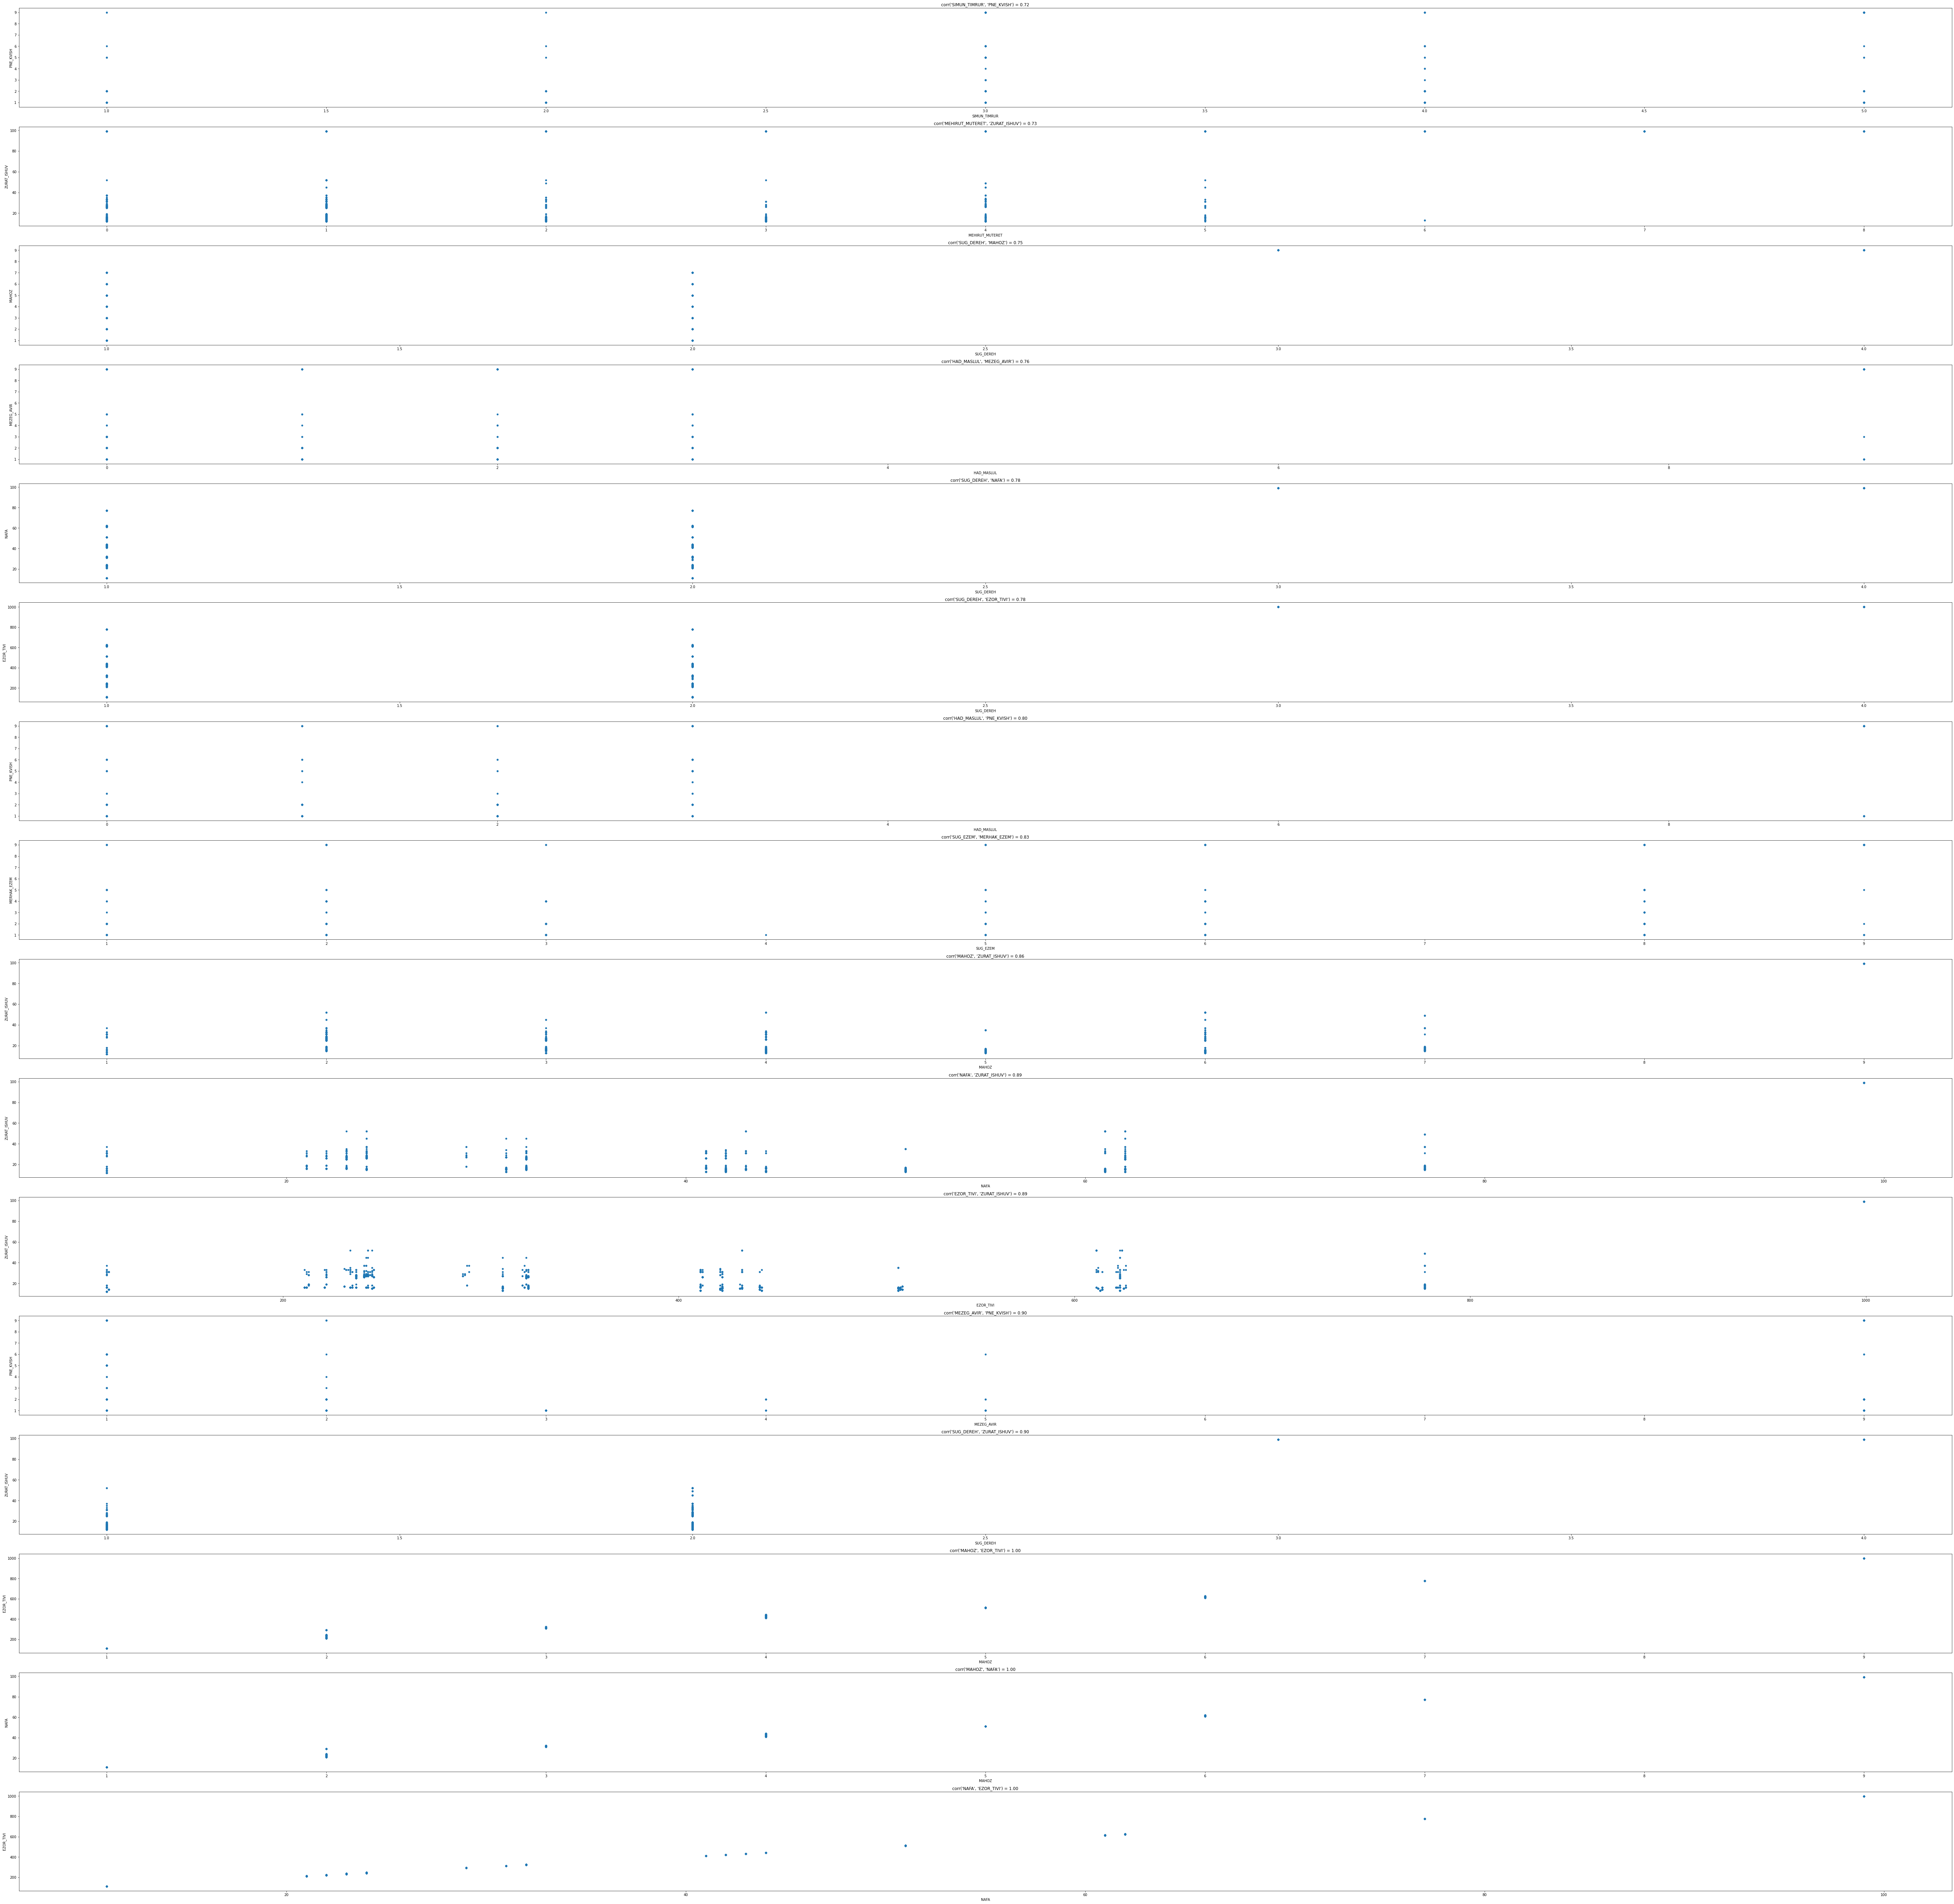

In [22]:
plot_high_correlated_scatters(df_cleaned)

### Remove correlated features
We'll be removing the correlated features as shown above from our data frame.

get_corr_cols(df,tuple_arr) function will save in a list all the feature names we wish to remove, which will come later. 

There is one exception however, we'll make an exception for feature X and Y as they are our very necessary features for predicting accidenst by location, we'll need them to mark down locations on the map.

In [23]:
def get_corr_cols(df,tuple_arr):
    feature_to_remove = set()
    num_of_col = np.array(tuple_arr)[:,1]
    for num in num_of_col:
        if num != 35 and num != 34:
            feature_to_remove.add(df.columns[num])
    return feature_to_remove

In [24]:
#X = 34 #Must keep
#Y = 35 #Must keep
tuple_arr.sort()
correlated_features = get_corr_cols(df_cleaned,tuple_arr)
#correlated_features.add(df_cleaned["SHNAT_TEUNA"]) #Add more features that aren't correlated but are assumed irrelevant.
correlated_features

{'EZOR_TIVI',
 'MAHOZ',
 'MERHAK_EZEM',
 'MEZEG_AVIR',
 'NAFA',
 'PNE_KVISH',
 'ZURAT_ISHUV'}

The following function will remove the features listed above. The shape function is for self check, to see how many features were removed.

In [25]:
df_cleaned.drop(labels=correlated_features, axis=1)
df_cleaned.shape

,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,YEHIDA,SHNAT_TEUNA,HODESH_TEUNA,SHAA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,HUMRAT_TEUNA,SUG_TEUNA,HAD_MASLUL,RAV_MASLUL,MEHIRUT_MUTERET,TKINUT,ROHAV,SIMUN_TIMRUR,TEURA,SUG_EZEM,LO_HAZA,OFEN_HAZIYA,MEKOM_HAZIYA,KIVUN_HAZIYA,STATUS_IGUN,X,Y
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018000004,1,1,1,841,51,2018,9,27,4,5,1,3,2,9,0,5,1,3,3,6,9,9,0,0,9,1,193498,673585
2,2018000018,1,1,1,4000,11,2018,6,67,4,1,1,3,2,2,0,1,1,2,3,1,9,9,0,0,9,1,200041,746160
3,2018000030,1,1,1,7100,38,2018,6,95,4,5,1,2,8,0,3,4,1,3,4,3,2,9,0,0,9,1,161755,620861
4,2018000037,1,1,4,0,12,2018,7,59,4,1,7,3,8,2,0,4,1,3,3,2,6,9,0,0,9,1,258984,768332
5,2018000049,1,1,3,0,11,2018,1,69,4,5,5,3,2,0,3,1,1,5,3,6,9,9,0,0,9,1,203320,743957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12496,2018099555,1,1,1,5000,20,2018,9,20,2,5,1,2,2,3,0,1,1,3,3,3,9,9,0,0,9,1,178801,663121
12497,2018099560,1,1,1,5000,20,2018,3,55,4,1,4,3,2,1,0,1,1,1,3,1,9,9,0,0,9,1,180659,667465
12498,2018099561,1,1,4,0,14,2018,6,61,4,1,2,3,9,3,0,4,1,3,3,1,9,9,0,0,9,1,240573,714606


(12477, 36)

In [26]:
#df_cleaned.isna().sum() - Double check to make sure there are no missing values

### Draw on map
In the next cell we'll draw a scatterplot where we'll mark down our X and Y coordinates. We expect something to resemble the map of Israel.

The first cell is to set up values to control the diagram size more easily and make sure the map ratio is consistent. We use the total number of values to do that task (the number of X values is equal to the number of Y values, however this can be accomplished in many other ways.

In [27]:
X_Mlen = max(df_cleaned['X']) #highest X value
Y_Mlen = max(df_cleaned['Y']) #highest Y value
X_Mlen = X_Mlen/Y_Mlen * 20
Y_Mlen = Y_Mlen/Y_Mlen * 20
#img = mpimg.imread('map_2.jpg') 

palette color is used to assign colours to each value in "HUMRAT_TEUNA" feature. 

Black is most sever accident, where as light blue is less severe.

fig, ax = plt.subplots creates a figure and a set of subplots, which allow us to draw.
sns.scatterplot - draws the dots on the figure.

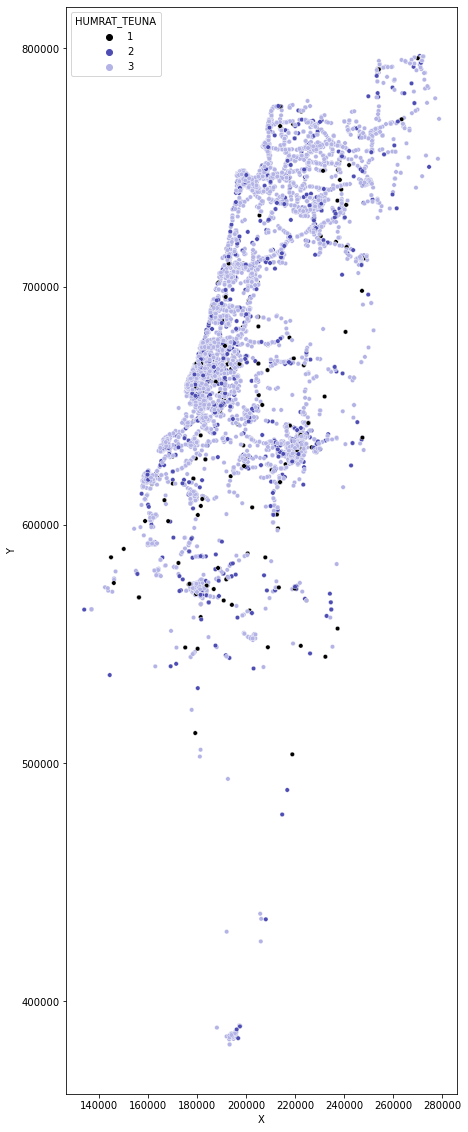

In [28]:
palette_color = [(0, 0, 0), (0.3, 0.3, 0.7), (0.7, 0.7, 0.9)] # (Red, Green, Blue)
fig, ax = plt.subplots(figsize=(X_Mlen, Y_Mlen))
plot = sns.scatterplot(x='X', y='Y', data=df_cleaned, hue='HUMRAT_TEUNA', palette=palette_color, legend=True, s=20)
plt.show()
#plot.get_xlim() + plot.get_ylim() - axis view limits. Meaning, start point and end point
#view_lim = plot.get_xlim() + plot.get_ylim()
#h, w, c = img.shape
#view_lim = [120000, 300000, 450000, 800000]
#plot.imshow(img, aspect = plot.get_aspect(), extent = view_lim)


# Machine Learning

### Split to train-test tables
In the next cell we'll seperate our target feature from the rest of the dataframe. Once that is done, we'll split the data that's left into train and test tables. 20% of the data will go towards testing.

In [29]:
df = df_cleaned
predict='HUMRAT_TEUNA' #reminder: 1 is high, 3 is low
y = df[predict]
X = df.drop(predict, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### Create lists for algorithms to test and their accuracy score
We'll create a list of algorithm we are going to use, and how accurate they were. Later, we'll determind which algorithm was the best to predict a heatmap based on severity.

In [30]:
algo_list=['Logistic Regression',' K-Nearest Neighbors','Decision Trees']
accuracy_list=[]

## KNN Algorithm
neighbors is a list of k neighbors we'll be testing the score for. We'll go from 7 to 67 while skipping 7.

train_accuracy will store all the accuracy results while the algorithm was training, and the test_accuracy will store the accuracy values testing that algorithm. We'll want to pick the K which has the smallest difference between the two results.

In [31]:
# Calculate the best k for the algorithm
neighbors = np.arange(7, 67, 10) #start, stop, step
train_accuracy = []
test_accuracy = []

for i, n_neighbor in enumerate(neighbors):   
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)
    knn.fit(X_train,y_train)
    train_accuracy.append(knn.score(X_train, y_train)) #train set accuracy
    test_accuracy.append(knn.score(X_test, y_test)) #test set accuracy

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=17)

KNeighborsClassifier(n_neighbors=27)

KNeighborsClassifier(n_neighbors=37)

KNeighborsClassifier(n_neighbors=47)

KNeighborsClassifier(n_neighbors=57)

Training accuracy starts high but starts dropping the more neighbors we increase. On the other hand, Test accuracy starts low but continues to grow in accuracy as we increase thosen neighbors. We'll want to pick the neighbor where the accuracy between these two variables is lowest.

In [32]:
def bestk(train_accuracy, test_accuracy):
    best_accuracy_diff = train_accuracy[0] - test_accuracy[0]
    best_k = 1
    for i in range(len(train_accuracy)):
        accuracy_diff = train_accuracy[i] - test_accuracy[i]
        if accuracy_diff < best_accuracy_diff:
            best_accuracy_diff = accuracy_diff
            best_k = neighbors[i]
    return best_k

In [33]:
bestk(train_accuracy, test_accuracy) #returns best K

37

### Visualize the best K through graph

Text(0.5, 1.0, 'KNN: Number of Neighbors')

Text(0.5, 0, 'Number of Neighbors')

Text(0, 0.5, 'Accuracy')

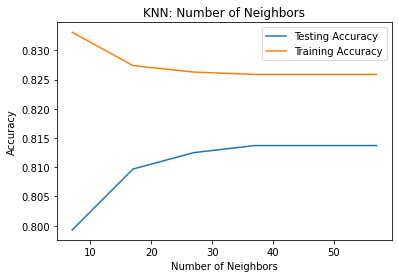

In [34]:
plt.title('KNN: Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [35]:
knn = KNeighborsClassifier(n_neighbors=37)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
acc=accuracy_score(y_test, y_pred)\

KNeighborsClassifier(n_neighbors=37)

In [36]:
accuracy_list.append(acc)
print('accuracy_score =', acc)

accuracy_score = 0.8137019230769231


## Logistic regression Algorithm

In [37]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

acc=accuracy_score(y_test, y_pred)

LogisticRegression(random_state=0)

In [38]:
accuracy_list.append(acc)
print("accuracy_score =",acc)

accuracy_score = 0.8137019230769231


## Decision Tree Algorithm - Expected to be the best algorithm
based on the journal we've read before selecting this topic, they ran through similar predictions and it seems like that decision tree was one among the most common algorithm used. While algorithms such as neural network preformed better, decision tree handled classification problems just as accurate at faster time.

Link to the journal: https://www.mdpi.com/2073-431X/10/12/157

In [47]:
def find_best_decision_tree_params(X_train, y_train):
    params = {"max_depth": np.arange(2, 8, 1), "min_samples_split": np.arange(2, 5, 1)}
    dtree = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dtree, params, scoring = make_scorer(metrics.f1_score, greater_is_better = True))
    clf.fit(X_train, y_train)
    best_max_depth = clf.best_params_["max_depth"]
    best_min_samples_split = clf.best_params_["min_samples_split"]
    best_f1_val = clf.best_score_
    return best_max_depth, best_min_samples_split, best_f1_val

In [48]:
best_max_dep, best_min_smpl_splt, best_f1_DT_params = find_best_decision_tree_params(X_train, y_train)

In [49]:
best_max_dep
best_f1_DT_params

2

nan

In [50]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1)
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy_score =', accuracy)

DecisionTreeClassifier(max_depth=5, random_state=1)

accuracy_score = 0.8225160256410257


In [51]:
# Append to the accuracy list
acc=accuracy
accuracy_list.append(acc)
print('accuracy_score =', accuracy)

accuracy_score = 0.8225160256410257


In [52]:
accuracy_list

[0.8137019230769231, 0.8137019230769231, 0.8225160256410257]

<AxesSubplot:>

Text(0.5, 0, 'Algorithm Score')

Text(0, 0.5, 'Accuracy Score')

Text(0.5, 1.0, 'Algorithm Score')

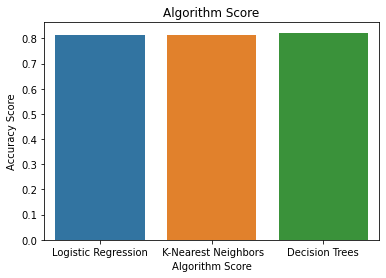

In [74]:
# Creating a bar plot, displaying score of each algorithm
sns.barplot(x=algo_list, y=accuracy_list)
# Add labels to graphs
plt.xlabel('Algorithm Score')
plt.ylabel('Accuracy Score')
plt.title("Algorithm Score")
plt.show()